In [31]:
# Pascal VOC Dataset Analysis
import os
import json
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import pandas as pd

# Constants
pascal_voc_classes = ['person', 'bird', 'cat', 'cow', 'dog', 'horse', 'sheep',
                      'aeroplane', 'bicycle', 'boat', 'bus', 'car', 'motorbike', 'train',
                      'bottle', 'chair', 'diningtable', 'pottedplant', 'sofa', 'tvmonitor']
pascal_label2int = {label: index for index, label in enumerate(pascal_voc_classes)}
pascal_int2label = {index: label for index, label in enumerate(pascal_voc_classes)}

# Helper Functions
def objects_to_labels(objects, num_classes=20):
    """
    Transforms objects to one-hot encoded labels.
    
    Args:
        objects: List of object names
        num_classes: Number of possible classes
        
    Returns:
        numpy array of binary labels (1 for present classes, 0 for absent)
    """
    labels = np.zeros(num_classes)
    for obj in objects:
        assert obj in pascal_voc_classes, f"{obj} not in Pascal VOC classes list"
        labels[pascal_label2int[obj]] = 1
    return labels

def parse_function(filename, label, data_dir):
    """Load image from filename and average all 3 channels into a single channel."""
    # Load the image from file
    filename = filename.numpy().decode("utf-8")
    data_dir = data_dir.numpy().decode("utf-8")
    image = np.load(os.path.join(data_dir, "classification", f"{filename}.npy"))
    
    # Average the three channels
    image_mean = np.mean(image, axis=-1)
    
    # Expand dimensions to make it (height, width, 1)
    image_mean = np.expand_dims(image_mean, axis=-1)
    
    return image_mean, label

def load_dataset_info(data_dir, split_list_file):
    """Load dataset information and return annotations and split files."""
    task_dir = os.path.join(data_dir, "classification")
    
    # Load annotations
    with open(os.path.join(task_dir, 'data.json'), 'r') as file:
        annotations = json.load(file)
    
    # Load split files
    with open(split_list_file) as file:
        split_files = [line.rstrip() for line in file]
    
    return annotations, split_files

def analyze_class_distribution(annotations, split_files):
    """Analyze the distribution of classes in the dataset."""
    # Count occurrences of each class
    class_counts = {cls: 0 for cls in pascal_voc_classes}
    
    for filename in split_files:
        objects = annotations[filename]
        for obj in objects:
            class_counts[obj] += 1
    
    # Convert to DataFrame for easier plotting
    df = pd.DataFrame(list(class_counts.items()), columns=['Class', 'Count'])
    df = df.sort_values('Count', ascending=False)
    
    # Calculate percentages
    total_annotations = df['Count'].sum()
    df['Percentage'] = (df['Count'] / total_annotations * 100).round(2)
    
    # Set the style for better default aesthetics
    plt.style.use('seaborn-v0_8')  # Alternative options: 'ggplot', 'bmh', 'classic'

    # Create bar plot with custom colors and figure size
    plt.figure(figsize=(12, 6))
    sns.barplot(
        data=df,
        x='Class',
        y='Count',
        color='#2E86C1',  # Nice blue shade
        alpha=0.8
    )

    # Customize the axes and labels
    plt.xlabel('Class Type', fontsize=12, fontweight='bold')
    plt.ylabel('Count', fontsize=12, fontweight='bold')
    plt.title('Class Distribution in Dataset', fontsize=14, pad=20)

    # Rotate x-axis labels for better readability
    plt.xticks(rotation=45, ha='right', fontsize=10)
    plt.yticks(fontsize=10)

    # Add grid for better readability
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    # Adjust layout to prevent label cutoff
    plt.tight_layout()

    plt.show()
    return df

def analyze_labels_per_image(annotations, split_files):
    """Analyze the distribution of number of labels per image."""
    labels_per_image = [len(annotations[filename]) for filename in split_files]
    
    plt.figure(figsize=(10, 5))
    plt.hist(labels_per_image, bins=range(1, max(labels_per_image) + 2), align='left')
    plt.title('Distribution of Labels per Image')
    plt.xlabel('Number of Labels')
    plt.ylabel('Number of Images')
    plt.grid(True, alpha=0.3)
    plt.show()
    
    stats = {
        'mean': np.mean(labels_per_image),
        'median': np.median(labels_per_image),
        'std': np.std(labels_per_image),
        'min': min(labels_per_image),
        'max': max(labels_per_image)
    }
    
    print("\nLabels per Image Statistics:")
    print(f"Average: {stats['mean']:.2f}")
    print(f"Median: {stats['median']:.2f}")
    print(f"Standard Deviation: {stats['std']:.2f}")
    print(f"Minimum: {stats['min']}")
    print(f"Maximum: {stats['max']}")
    
    return stats

def analyze_label_correlations(annotations, split_files):
    """Analyze correlations between different classes."""
    # Create binary matrix for all images
    label_matrix = np.zeros((len(split_files), len(pascal_voc_classes)))
    
    for i, filename in enumerate(split_files):
        objects = annotations[filename]
        label_matrix[i] = objects_to_labels(objects)
    
    # Calculate correlation matrix
    corr_matrix = np.corrcoef(label_matrix.T)
    
    # Plot correlation matrix
    plt.figure(figsize=(12, 10))
    sns.heatmap(corr_matrix, xticklabels=pascal_voc_classes, yticklabels=pascal_voc_classes,
                cmap='coolwarm', center=0, annot=True, fmt='.2f', square=True)
    plt.title('Class Correlation Matrix')
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()
    
    # Find strongest positive correlations
    correlations = []
    for i in range(len(pascal_voc_classes)):
        for j in range(i+1, len(pascal_voc_classes)):
            correlations.append((
                pascal_voc_classes[i],
                pascal_voc_classes[j],
                corr_matrix[i,j]
            ))
    
    top_correlations = sorted(correlations, key=lambda x: abs(x[2]), reverse=True)[:5]
    print("\nTop 5 strongest class correlations:")
    for c1, c2, corr in top_correlations:
        print(f"{c1} - {c2}: {corr:.3f}")

def display_sample_images(data_dir, annotations, split_files, num_samples=5):
    """Display sample images with their labels."""
    # Randomly select images
    selected_files = np.random.choice(split_files, num_samples, replace=False)
    
    fig, axes = plt.subplots(1, num_samples, figsize=(20, 4))
    for i, filename in enumerate(selected_files):
        # Load image
        image = np.load(os.path.join(data_dir, "classification", f"{filename}.npy"))
        #image_mean = np.mean(image, axis=-1)
        
        # Display image
        axes[i].imshow(image)#, cmap='gray')
        axes[i].axis('off')
        
        # Add labels as title
        labels = annotations[filename]
        title = "\n".join([f"{label}" for label in labels])
        axes[i].set_title(title, fontsize=8)
    
    plt.tight_layout()
    plt.show()

In [32]:
plt.style.available

['Solarize_Light2',
 '_classic_test_patch',
 '_mpl-gallery',
 '_mpl-gallery-nogrid',
 'bmh',
 'classic',
 'dark_background',
 'fast',
 'fivethirtyeight',
 'ggplot',
 'grayscale',
 'seaborn-v0_8',
 'seaborn-v0_8-bright',
 'seaborn-v0_8-colorblind',
 'seaborn-v0_8-dark',
 'seaborn-v0_8-dark-palette',
 'seaborn-v0_8-darkgrid',
 'seaborn-v0_8-deep',
 'seaborn-v0_8-muted',
 'seaborn-v0_8-notebook',
 'seaborn-v0_8-paper',
 'seaborn-v0_8-pastel',
 'seaborn-v0_8-poster',
 'seaborn-v0_8-talk',
 'seaborn-v0_8-ticks',
 'seaborn-v0_8-white',
 'seaborn-v0_8-whitegrid',
 'tableau-colorblind10']

In [33]:

# Example usage:
#data_dir = "/path/to/your/data"  # Update this path
#metadata_dir = "/path/to/metadata"  # Update this path

data_path = os.path.join("F:\\ssl_images\\data")
data_dir = os.path.join(data_path, "processed", "pascal_voc")
metadata_dir = os.path.join(data_path, "pascal_voc", "ImageSets", "Main")


# Analyze training set
print("Loading dataset information...")
train_annotations, train_split_files = load_dataset_info(
    data_dir, 
    os.path.join(metadata_dir, "train.txt")
)

print("\nDataset Overview:")
print("-" * 50)
print(f"Total number of images: {len(train_split_files)}")


Loading dataset information...

Dataset Overview:
--------------------------------------------------
Total number of images: 5717



Analyzing class distribution...


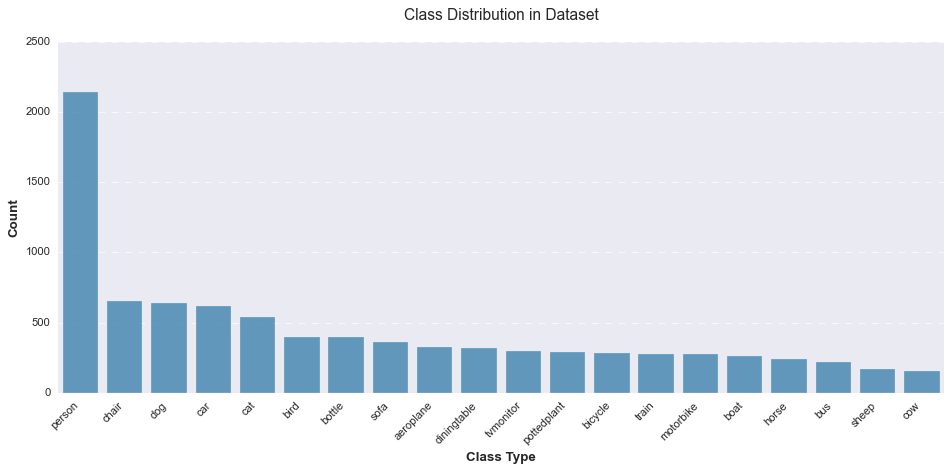


Class Distribution Summary:
          Class  Count  Percentage
0        person   2142       24.17
15        chair    656        7.40
4           dog    636        7.18
11          car    621        7.01
2           cat    540        6.09
1          bird    399        4.50
14       bottle    399        4.50
18         sofa    359        4.05
7     aeroplane    328        3.70
16  diningtable    318        3.59
19    tvmonitor    299        3.37
17  pottedplant    289        3.26
8       bicycle    281        3.17
13        train    275        3.10
12    motorbike    274        3.09
9          boat    264        2.98
5         horse    238        2.69
10          bus    219        2.47
6         sheep    171        1.93
3           cow    155        1.75


In [34]:

# Analyze and plot class distribution
print("\nAnalyzing class distribution...")
class_dist_df = analyze_class_distribution(train_annotations, train_split_files)
print("\nClass Distribution Summary:")
print(class_dist_df)



Analyzing labels per image distribution...


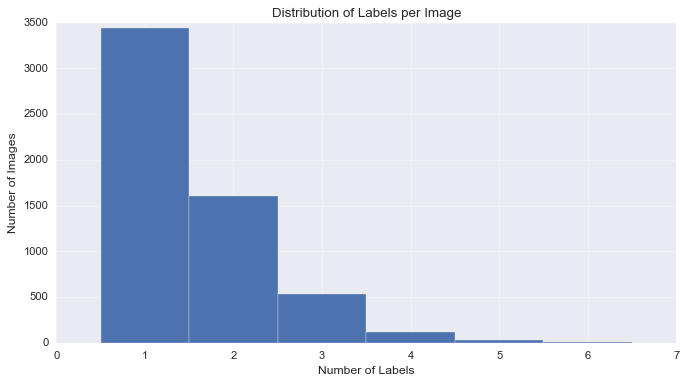


Labels per Image Statistics:
Average: 1.55
Median: 1.00
Standard Deviation: 0.79
Minimum: 1
Maximum: 6


In [35]:

# Analyze labels per image
print("\nAnalyzing labels per image distribution...")
label_stats = analyze_labels_per_image(train_annotations, train_split_files)



Analyzing label correlations...


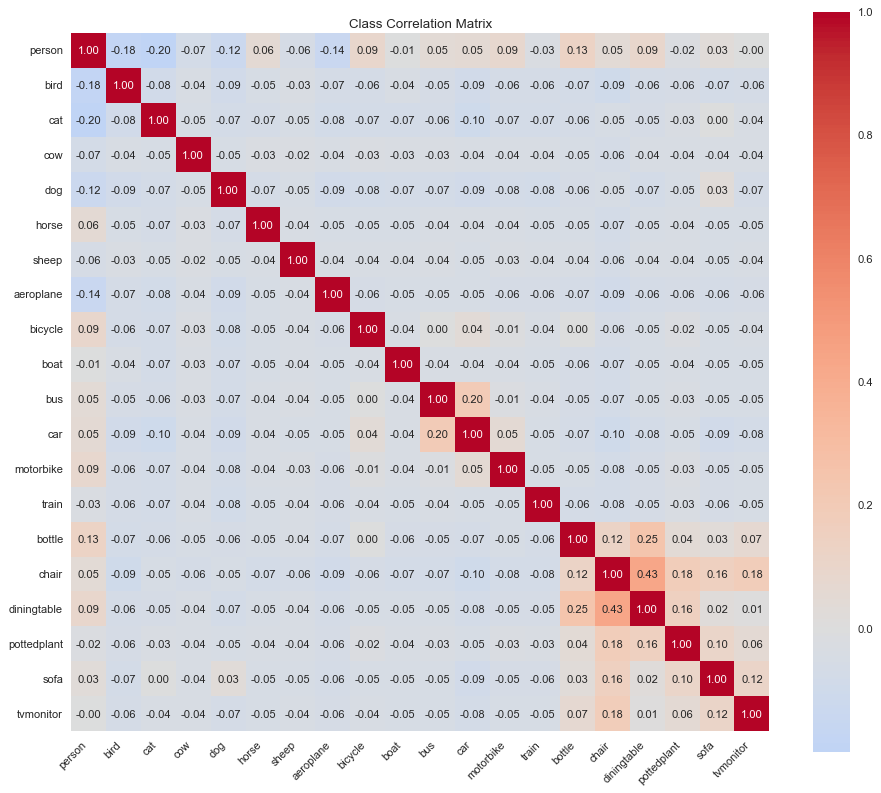


Top 5 strongest class correlations:
chair - diningtable: 0.432
bottle - diningtable: 0.245
person - cat: -0.199
bus - car: 0.197
chair - tvmonitor: 0.184


In [36]:
# Analyze label correlations
print("\nAnalyzing label correlations...")
analyze_label_correlations(train_annotations, train_split_files)



Displaying sample images...


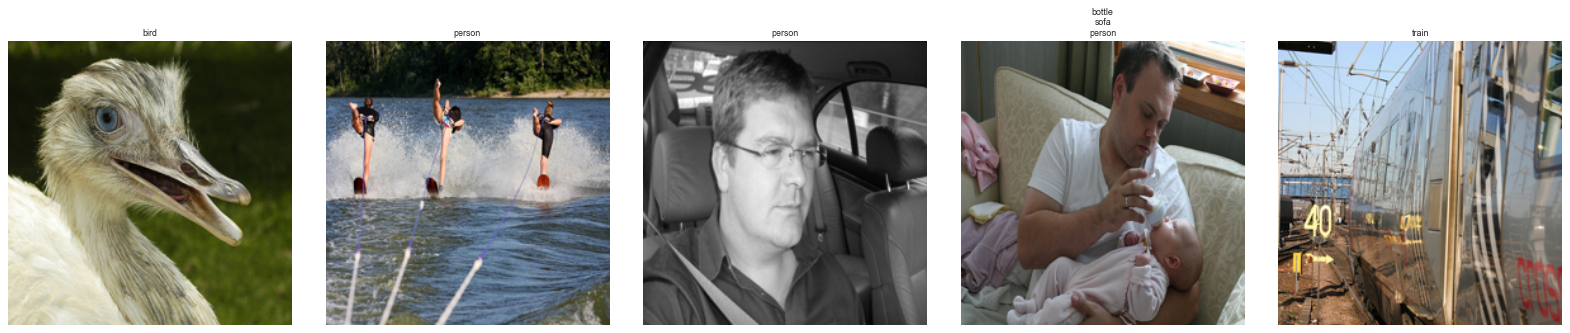

In [37]:
# Display sample images
print("\nDisplaying sample images...")
display_sample_images(data_dir, train_annotations, train_split_files)

In [83]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model

# Import your ResNet implementation 
from src.models.resnet import ResNet18, ResNet50, load_encoder_weights
from src.libs.data_loading import create_dataset

import cv2  

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    """Generate Grad-CAM heatmap for a given image and model."""
    # Create a model that maps the input image to the activations
    # of the last conv layer and output predictions
    grad_model = Model(
        [model.inputs], 
        [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron with respect to
    # the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)
    # Vector of mean intensity of the gradient over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # Weight the channels by the computed pooled gradients
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.maximum(tf.reduce_max(heatmap), 1e-10)

    heatmap = tf.maximum(heatmap, 0) / tf.maximum(tf.reduce_max(heatmap), 1e-10)
    heatmap = cv2.resize(heatmap.numpy(), (img_array.shape[1], img_array.shape[2]))  # Redimensiona o heatmap para 224x224
    return heatmap

def plot_gradcam(image, heatmap, alpha=0.4):
    """Plot the original image and its Grad-CAM heatmap overlay."""
    # Rescale heatmap to 0-255
    heatmap = np.uint8(255 * heatmap)
    
    # Use jet colormap to colorize heatmap
    jet = plt.cm.get_cmap("jet")
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]
    
    # Resize jet_heatmap to match the original image size
    jet_heatmap = cv2.resize(jet_heatmap, (image.shape[1], image.shape[0]))

    # Normalize the original image
    image = (image - np.min(image)) / (np.max(image) - np.min(image))
    
    # Convert grayscale image to RGB for visualization
    if image.shape[-1] == 1:  # Check if the image is grayscale
        image = np.stack([image.squeeze()] * 3, axis=-1)

    # Superimpose the heatmap onto the original image
    superimposed_img = image * (1 - alpha) + jet_heatmap * alpha
    superimposed_img = np.clip(superimposed_img, 0, 1)
    
    # Plot
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
    
    ax1.imshow(image)
    ax1.set_title('Original Image')
    ax1.axis('off')
    
    ax2.imshow(heatmap, cmap='jet')
    ax2.set_title('Grad-CAM Heatmap')
    ax2.axis('off')
    
    ax3.imshow(superimposed_img)
    ax3.set_title('Grad-CAM Overlay')
    ax3.axis('off')
    
    plt.tight_layout()
    plt.show()



# Function to show multiple images with their activations
def visualize_multiple_samples(model, dataset, num_samples=3):
    """Visualize Grad-CAM for multiple samples from the dataset."""
    for _ in range(num_samples):
        image_batch, label_batch = next(iter(dataset))
        predictions = model.predict(image_batch)

        # Get indices of top 3 predictions
        top3_indices = predictions[0].argsort()[-3:][::-1]  # Sort in descending order and get top 3
        top3_classes = [pascal_voc_classes[idx] for idx in top3_indices]
        top3_confidences = predictions[0][top3_indices]

        # Generate Grad-CAM for each of the top 3 predicted classes
        for class_idx, class_name, confidence in zip(top3_indices, top3_classes, top3_confidences):
            # Generate heatmap
            heatmap = make_gradcam_heatmap(
                image_batch,
                model,
                'block_3_1', 
                pred_index=class_idx
            )
            
            print(f"\nVisualization for class: {class_name}")
            print(f"Prediction confidence: {confidence:.3f}")
            
            # Plot results
            plot_gradcam(image_batch[0].numpy(), heatmap)


In [116]:


# Load the model and weights
model = ResNet50((224, 224, 1), mode="classification")
model.load_weights(os.path.join("models", "finetune_resnet50_new_loss", "model_epoch_04_loss_0.76.h5"))  # Update with your model path

#model = ResNet18((224, 224, 1), mode="classification")
#model.load_weights(os.path.join("models", "finetune_resnet18_mae", "model_epoch_05_loss_0.32.h5"))

# Create dataset and get one batch
dataset = create_dataset(
    data_dir, 
    split_list_file=os.path.join(metadata_dir, "val.txt"), 
    batch_size=1
)
image_batch, label_batch = next(iter(dataset))

# Get model predictions
predictions = model.predict(image_batch)
# Get indices of top 3 predictions
top3_indices = predictions[0].argsort()[-3:][::-1]  # Sort in descending order and get top 3
top3_classes = [pascal_voc_classes[idx] for idx in top3_indices]
top3_confidences = predictions[0][top3_indices]


1/1 [==============================] - 1s 804ms/step


In [117]:
label_batch

<tf.Tensor: shape=(1, 20), dtype=float32, numpy=
array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.]], dtype=float32)>

In [118]:
predictions

array([[0.2651408 , 0.46520445, 0.78424513, 0.24200152, 0.86792326,
        0.13741836, 0.592356  , 0.027325  , 0.00764468, 0.06551018,
        0.00454715, 0.01568024, 0.01140932, 0.00699633, 0.02149606,
        0.17715418, 0.0069919 , 0.03292362, 0.3443621 , 0.03387986]],
      dtype=float32)


Visualization for class: dog
Prediction confidence: 0.868


C:\Users\gabri\AppData\Local\Temp\ipykernel_9040\1030927689.py:53: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = plt.cm.get_cmap("jet")


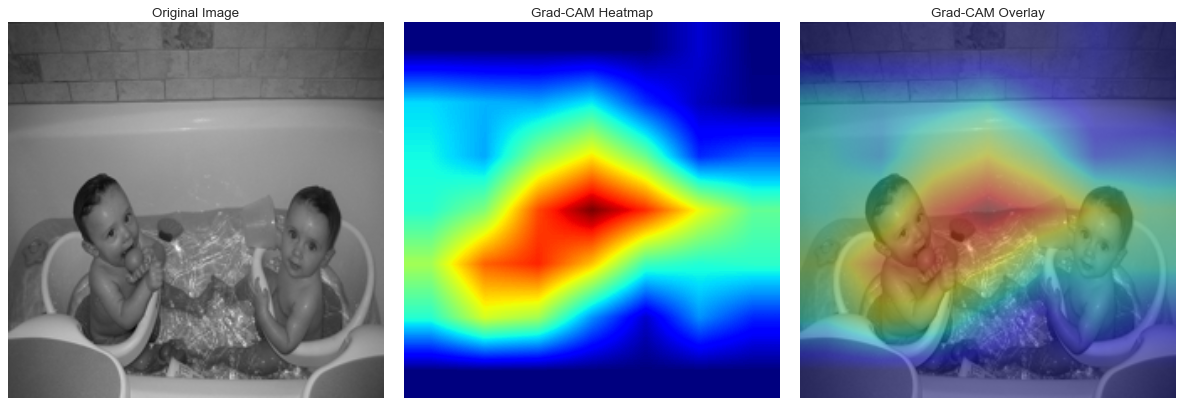


Visualization for class: cat
Prediction confidence: 0.784


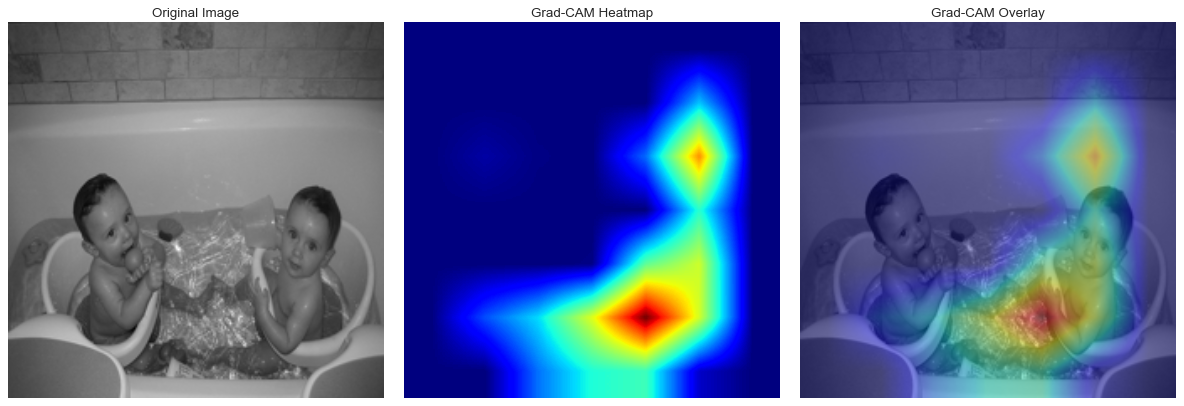


Visualization for class: sheep
Prediction confidence: 0.592


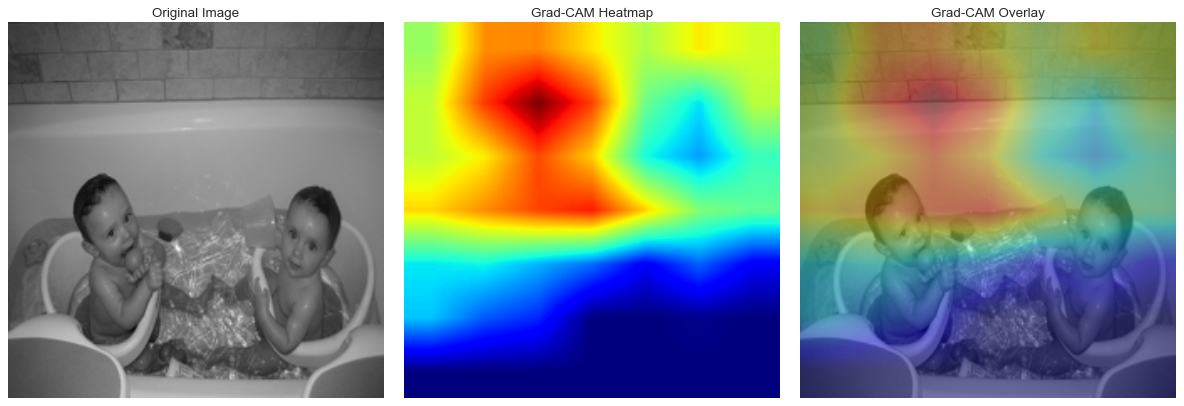

In [119]:

# Generate Grad-CAM for each of the top 3 predicted classes
for class_idx, class_name, confidence in zip(top3_indices, top3_classes, top3_confidences):
    # Generate heatmap
    heatmap = make_gradcam_heatmap(
        image_batch,
        model,
        'block_3_1',  
        pred_index=class_idx
    )
    
    print(f"\nVisualization for class: {class_name}")
    print(f"Prediction confidence: {confidence:.3f}")
    
    # Plot results
    plot_gradcam(image_batch[0].numpy(), heatmap)


Visualizing Grad-CAM for multiple samples...
1/1 [==============================] - 0s 73ms/step

Visualization for class: dog
Prediction confidence: 0.857


C:\Users\gabri\AppData\Local\Temp\ipykernel_9040\1030927689.py:53: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = plt.cm.get_cmap("jet")


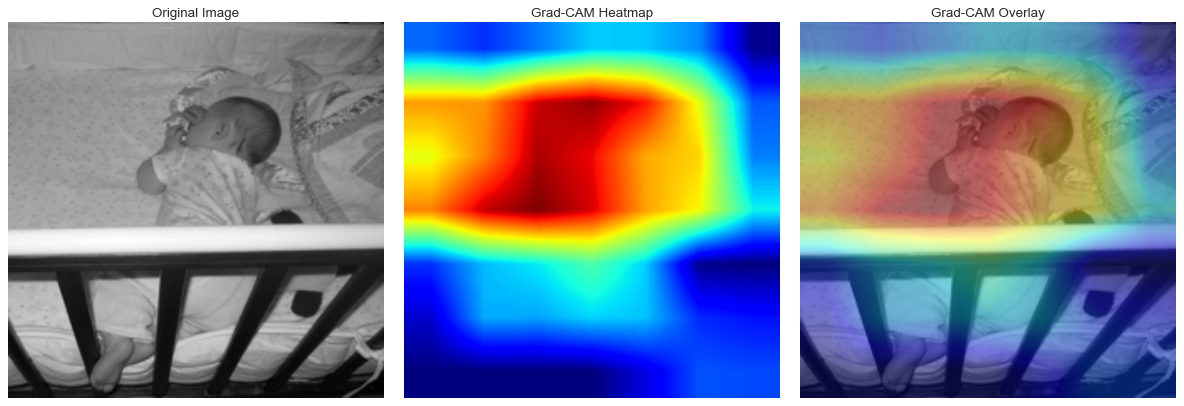


Visualization for class: cat
Prediction confidence: 0.679


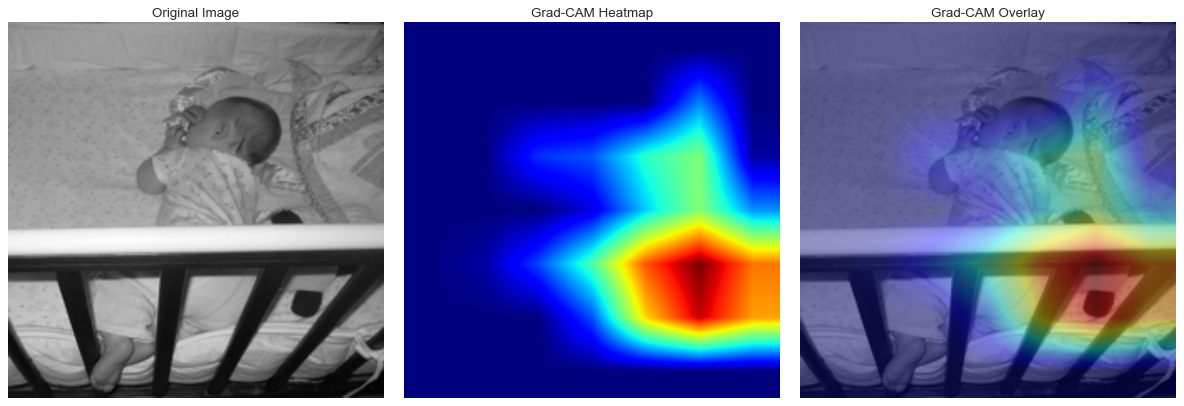


Visualization for class: person
Prediction confidence: 0.412


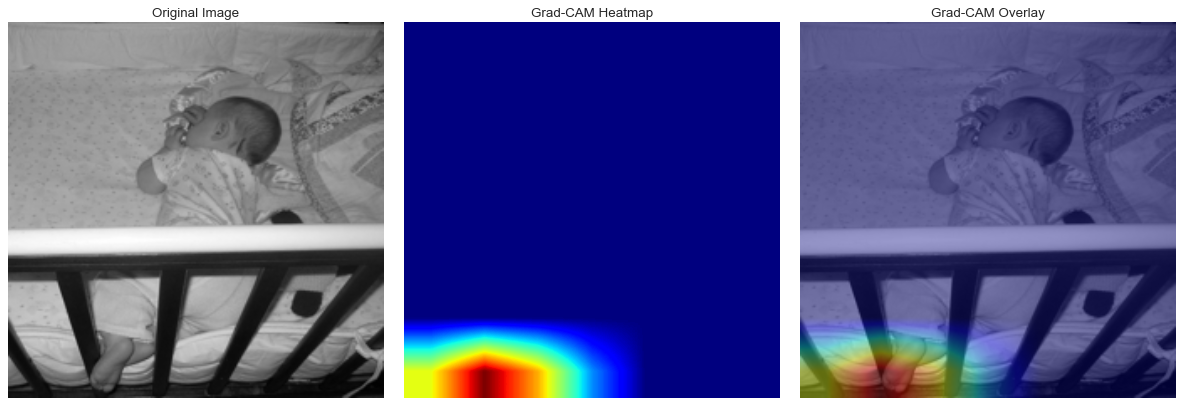

1/1 [==============================] - 0s 73ms/step

Visualization for class: person
Prediction confidence: 0.847


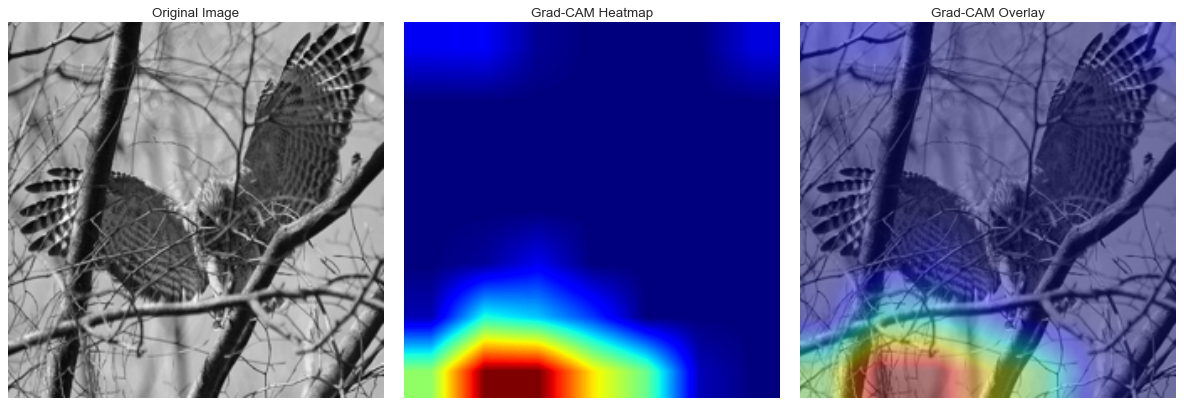


Visualization for class: bird
Prediction confidence: 0.715


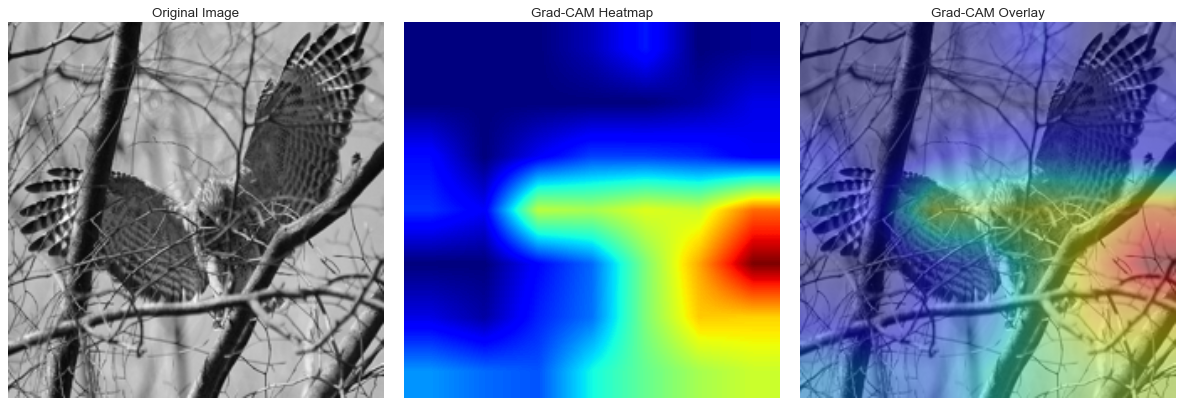


Visualization for class: dog
Prediction confidence: 0.617


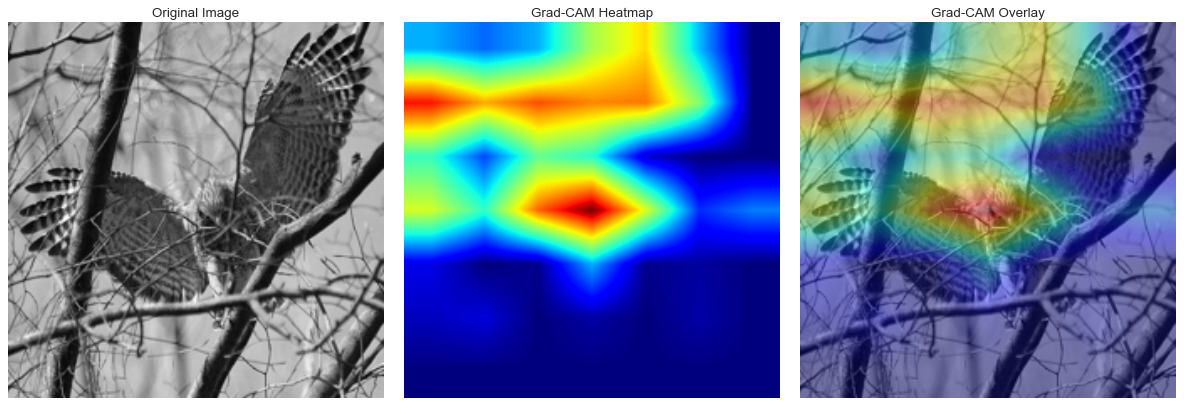

1/1 [==============================] - 0s 73ms/step

Visualization for class: person
Prediction confidence: 0.847


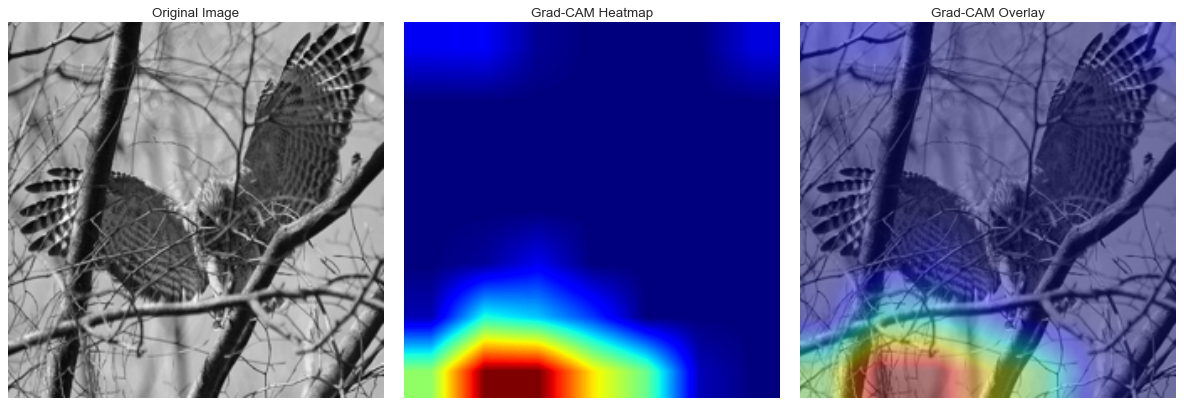


Visualization for class: bird
Prediction confidence: 0.715


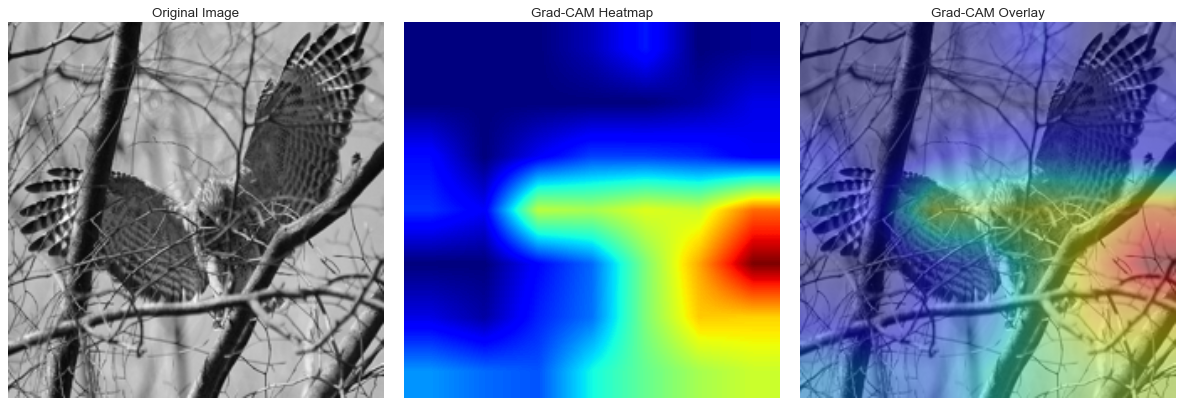


Visualization for class: dog
Prediction confidence: 0.617


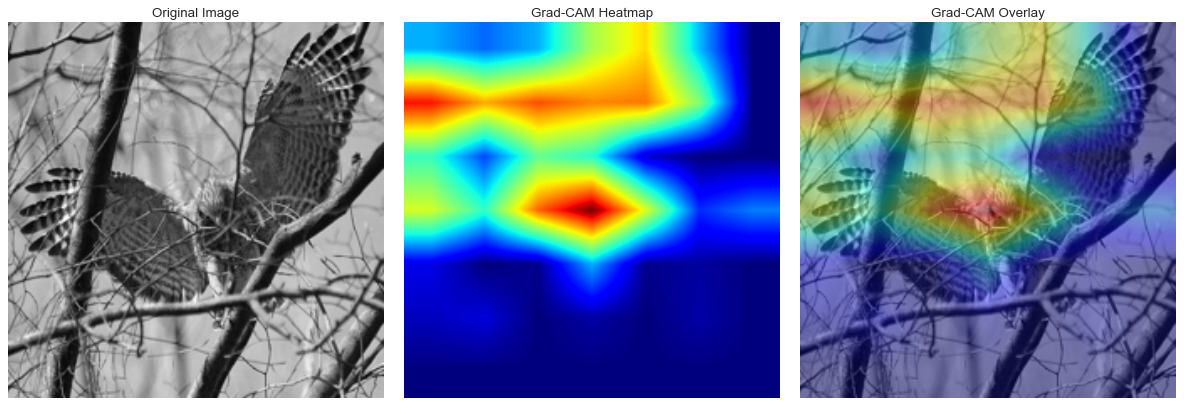

In [120]:

# Visualize multiple samples
print("Visualizing Grad-CAM for multiple samples...")
visualize_multiple_samples(model, dataset)